In [1]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import pickle
import random
import re

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import hmean
import xgboost as xgb
from sklearn.dummy import DummyRegressor

In [2]:
# Load Data Sets from CSV files
# df20 are patter based features (i.e signatures based on presence or absence of a AA)
# dfvz is the experimental data combined with features i.e zhse v-scale factors etc. 

dfvz = pd.read_csv('../DataFiles/experimental_data_set.csv', engine='c', index_col=0)
df20 = pd.read_csv('../DataFiles/df20.csv', engine='c', index_col=0)

# Indices of both DFs are matched during pre-processing so keep that in check!

In [3]:
def filter_data(dfvz=dfvz):
    # Filter Includes All Samples Containing Cysteine
    filter_cys = dfvz['seq'].str.contains('C')

    # Filter Includes All Samples Containing Proline in First Position but not in Second Position
    # I.e PCEQ is included but not PPEQ
    filter_proline = dfvz['seq'].str.contains('(^P[^P])')

    # Combined Filter to select any samples that satisfy either condition!
    filter_proline_cysteine = dfvz['seq'].str.contains('(^P[^P])|([C])')

    # Create index so it can be used for both DF20 and DFVZ (inverted to remove filtered rows)
    idx_filter_inverted = dfvz[~filter_proline_cysteine].index.to_list()

    print(f'Original Data Set Samples: {len(dfvz)}\
        \nSamples Containing Cystiene Residues: {len(dfvz[filter_cys])}\
        \nSamples Containing Proline (But Not Proline-Proline) {len(dfvz[filter_proline])}\
        \nTotal Samples that satisfy either condition (Some Overlap) {len(dfvz[filter_proline_cysteine])}\
        \nFinal Samples Used: {len(idx_filter_inverted)}\
        \nPercentage Removed: {len(idx_filter_inverted)/len(dfvz):.2%}')
    
    return idx_filter_inverted

filtered_indices = filter_data()

# Removes all Samples Containing C and PXXX where X != P
dfvz = dfvz.loc[filtered_indices]
df20 = df20.loc[filtered_indices]

/home/sharyarmemon/anaconda3/envs/gesar-linux/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Original Data Set Samples: 67278        
Samples Containing Cystiene Residues: 2740        
Samples Containing Proline (But Not Proline-Proline) 4328        
Total Samples that satisfy either condition (Some Overlap) 6846        
Final Samples Used: 60432        
Percentage Removed: 89.82%


### Use Standard Scaler on Features

$$ z = \frac{x-\mu}{\sigma}$$
Essentially, centers and scales the features. This is done column wise / feature wise. 

In [4]:
# This distribution of features allows us to experiment with each group individual as needed. 
# For now, we just need Xpvz_s and Xpvz_names. 
# Functionalized to reduce use of memory for variables
def scale_data(dfvz=dfvz, df20=df20):
    standard_scaler = preprocessing.StandardScaler()

    Xp = df20.loc[:,'..AA':'V...'].values #sequence pattern descriptors #(67278, 2396)
    Xp_names = df20.loc[:,'..AA':'V...'].columns
    standard_scaler.fit(Xp)
    Xp_s= standard_scaler.transform(Xp)

    Xz=dfvz.loc[:,'z1.1':'z4.3'].values #zscale descriptors #(67278, 12)
    Xz_names = dfvz.loc[:,'z1.1':'z4.3'].columns
    standard_scaler.fit(Xz)
    Xz_s= standard_scaler.transform(Xz)

    Xv=dfvz.loc[:,'vhse1.1':'vhse4.8'].values #vhse descriptors #(67278, 32)
    Xv_names = dfvz.loc[:,'vhse1.1':'vhse4.8'].columns
    standard_scaler.fit(Xv)
    Xv_s= standard_scaler.transform(Xv)

    Xvz_names = list(Xz_names)+list(Xv_names) #zscale and vhse combined #(67278, 44)
    Xvz=dfvz.loc[:,Xvz_names].values
    standard_scaler.fit(Xvz)
    Xvz_s= standard_scaler.transform(Xvz)

    Xpvz_names = list(Xvz_names)+list(Xp_names)#pattern and zscale, vhse combined #(67278, 2440)
    Xpvz=pd.concat([dfvz.loc[:,Xvz_names],df20.loc[:,list(Xp_names)]],axis=1).values
    standard_scaler.fit(Xpvz)
    Xpvz_s= standard_scaler.transform(Xpvz)

    y = dfvz['log.label'].values.reshape(-1,1)

    # The following dictionary makes it much easier to main and access data. 

    keys = ['Xp', 'Xp_s', 'Xz', 'Xz_s', 'Xv', 'Xv_s', 'Xvz', 'Xvz_s', 'Xpvz', 'Xpvz_s']
    vals = [Xp, Xp_s, Xz, Xz_s, Xv,Xv_s, Xvz, Xvz_s, Xpvz, Xpvz_s]
    name_vals = [Xp_names, Xp_names, Xz_names, Xz_names, Xv_names, Xv_names, Xvz_names, Xvz_names, Xpvz_names, Xpvz_names]

    X_dict = dict(zip(keys, vals))
    Xname_dict = dict(zip(keys, name_vals))

    # Y - Values, subdivided according to this: 
    # Real: Real Values used for regressor
    # 3class: 0, 1, 2 - Bottom 5%, Middle 90%, Top 5%
    threashold = 0.05
    y_three_class = pd.qcut(dfvz['log.label'], q = [0, threashold, 1-threashold, 1], labels=False).values
    y_low = np.array([True if x == 0 else False for x in y_three_class])
    y_high = np.array([True if x == 2 else False for x in y_three_class])
    ykey = ['real', '3class', 'low', 'high']
    yval = [y, y_three_class, y_low, y_high]
    y_dict = dict(zip(ykey, yval))

    return X_dict, Xname_dict, y_dict

X_dict, Xname_dict, y_dict = scale_data()

In [5]:
# Assign X & y values to be used for training/testing etc. 
X = X_dict['Xpvz_s']
y = y_dict['real']

# Details about the current data and its range:
print(f'Y - Value: LogDC \
    \nMax Y Value: {np.max(y)} \nMin Y Value: {np.min(y)} \
    \nAverage Y Value: {np.average(y)} \
    \nLength of Y: {len(y)} \
    \nShape of X: {X.shape}')

Y - Value: LogDC     
Max Y Value: -1.826188 
Min Y Value: -4.439897     
Average Y Value: -2.7528466023779985     
Length of Y: 60432     
Shape of X: (60432, 2440)


### PCA & T-SNE Clustering to view Feature Space Overlap

In [ ]:
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
# from collections import OrderedDict
# from functools import partial
# from time import time

# methods = OrderedDict()
# methods['t-SNE'] = TSNE(n_components=2, init='pca',
#                                  random_state=0)
# methods['PCA'] = PCA(n_components=2, random_state=0)

# for i, (label, method) in enumerate(methods.items()):
#     t0 = time()
#     Y = method.fit_transform(X)
#     t1 = time()
#     print("%s: %.2g sec" % (label, t1 - t0))
#     ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
#     ax.scatter(Y[:, 0], Y[:, 1], c=y, cmap=plt.cm.Spectral)
#     ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
#     ax.xaxis.set_major_formatter(NullFormatter())
#     ax.yaxis.set_major_formatter(NullFormatter())
#     ax.axis('tight')

# plt.show()

## Test Performance of Regressor in a Cross-Validation Setting

The final model will be trained on all of the data. 

In [6]:
scoring = {'mse':'neg_mean_squared_error', 'r2':'r2', 'mae':'neg_mean_absolute_error'}

def test_model(estimator, X, y, scoring=scoring, cv=5):
    scores = cross_validate(estimator, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=5)
    df = pd.DataFrame(scores)
    return df

In [7]:
# Parameters based on optimization done previously. 
params = {'n_estimators': 500,
          'learning_rate': 0.01,
          'objective':'reg:squarederror',                                   
          'n_jobs':-1,
          'verbosity':1,
          'tree_method':'gpu_hist'
          }

In [ ]:
regression_model = xgb.XGBRegressor(**params)
dummy_model = DummyRegressor(strategy='mean')
score_df_xgb = test_model(regression_model, X, y, cv=5)
score_df_dummy = test_model(dummy_model, X, y, cv=5)

In [ ]:
score_combined = pd.concat([score_df_xgb, score_df_dummy], keys=['xgb', 'dummy'])
aggregated_scores = score_combined.groupby(level=0).agg({'test_mse':['mean','std'],\
    'test_r2':['mean', 'std'],
    'test_mae':['mean', 'std']})

aggregated_scores.to_csv('summary_scores_regressor.csv')

## Train Regressor on Entire Data Set & Compute Statistics

In [8]:
X_train, X_validate, y_train, y_validate = train_test_split(
    X, y, test_size=0.1, stratify=y_dict['3class'], shuffle=True, random_state=42
)

regression_model_final = xgb.XGBRegressor(**params)
regression_model_final.fit(
    X_train, y_train,
    eval_set=[(X_validate, y_validate)],
    early_stopping_rounds=3,
    eval_metric=['mae', 'rmse']
)


[0]	validation_0-mae:3.22140	validation_0-rmse:3.23637
Multiple eval metrics have been passed: 'validation_0-rmse' will be used for early stopping.

Will train until validation_0-rmse hasn't improved in 3 rounds.
[1]	validation_0-mae:3.18920	validation_0-rmse:3.20428
[2]	validation_0-mae:3.15733	validation_0-rmse:3.17252
[3]	validation_0-mae:3.12578	validation_0-rmse:3.14107
[4]	validation_0-mae:3.09453	validation_0-rmse:3.10993
[5]	validation_0-mae:3.06361	validation_0-rmse:3.07912
[6]	validation_0-mae:3.03299	validation_0-rmse:3.04861
[7]	validation_0-mae:3.00267	validation_0-rmse:3.01841
[8]	validation_0-mae:2.97266	validation_0-rmse:2.98852
[9]	validation_0-mae:2.94295	validation_0-rmse:2.95892
[10]	validation_0-mae:2.91353	validation_0-rmse:2.92962
[11]	validation_0-mae:2.88441	validation_0-rmse:2.90062
[12]	validation_0-mae:2.85558	validation_0-rmse:2.87192
[13]	validation_0-mae:2.82704	validation_0-rmse:2.84350
[14]	validation_0-mae:2.79879	validation_0-rmse:2.81537
[15]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=1)

In [9]:
# Assign weight 3 to top and bottom 5 to optimize for them! 
weights = [2 if (x == 1) or (x == 2) else 1 for x in y_dict['3class']]
X_train, X_validate, y_train, y_validate, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.1, stratify=y_dict['3class'], shuffle=True, random_state=42
)

regression_model_weighted = xgb.XGBRegressor(**params)
regression_model_weighted.fit(
    X_train, y_train,
    eval_set=[(X_validate, y_validate)],
    early_stopping_rounds=3,
    eval_metric=['mae', 'rmse'],
    sample_weight=weights_train
)

[0]	validation_0-mae:3.22160	validation_0-rmse:3.23657
Multiple eval metrics have been passed: 'validation_0-rmse' will be used for early stopping.

Will train until validation_0-rmse hasn't improved in 3 rounds.
[1]	validation_0-mae:3.18960	validation_0-rmse:3.20469
[2]	validation_0-mae:3.15793	validation_0-rmse:3.17313
[3]	validation_0-mae:3.12657	validation_0-rmse:3.14188
[4]	validation_0-mae:3.09553	validation_0-rmse:3.11096
[5]	validation_0-mae:3.06480	validation_0-rmse:3.08034
[6]	validation_0-mae:3.03438	validation_0-rmse:3.05003
[7]	validation_0-mae:3.00426	validation_0-rmse:3.02002
[8]	validation_0-mae:2.97444	validation_0-rmse:2.99032
[9]	validation_0-mae:2.94492	validation_0-rmse:2.96092
[10]	validation_0-mae:2.91569	validation_0-rmse:2.93182
[11]	validation_0-mae:2.88676	validation_0-rmse:2.90300
[12]	validation_0-mae:2.85811	validation_0-rmse:2.87448
[13]	validation_0-mae:2.82976	validation_0-rmse:2.84625
[14]	validation_0-mae:2.80168	validation_0-rmse:2.81830
[15]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=1)

In [23]:
def custom_scorer(y_true, y_predicted):
    r2 = r2_score(y_true, y_predicted)
    mae = mean_absolute_error(y_true, y_predicted)
    rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
    return {'r2':r2, 'mae':mae, 'rmse':rmse}



def test_weighted(trained_models_with_names, X, y):
    X_top, y_top = X[y_dict['high']], y[y_dict['high']]
    X_bottom, y_bottom = X[y_dict['low']], y[y_dict['low']]

    f, axes = plt.subplots(3,2, figsize=(15,10))

    scores_dict_top = {}
    scores_dict_bottom = {}
    for i, (name, model) in enumerate(trained_models_with_names.items()):
        print(f'Testing Model {name}')
        
        predictions_top = model.predict(X_top)
        predictions_bottom = model.predict(X_bottom)

        sns.histplot(predictions_top, color='red', ax=axes[i,0])
        sns.histplot(y_top, color='blue', ax=axes[i,0])
        axes[i,0].set(xlim=(-4.7,-1.8))
        

        sns.histplot(predictions_bottom, color='red', ax=axes[i,1])
        sns.histplot(y_bottom, color='blue', ax=axes[i,1])
        axes[i,1].set(xlim=(-4.7,-1.8))
        
        print(y_bottom.shape)
        print(predictions_bottom.shape)
        

        # print(f'Real Y-Top Values: \n{y_top[0:5]}\
        #     \nPredicted Top Values: \n{predictions_top[0:5].reshape(-1,1)}\
        #     \nReal Y-Bot Values: \n{y_bottom[0:5]}\
        #     \nPredicted Bot Values: \n{predictions_bottom[0:5].reshape(-1,1)}\n')
        scores_dict_top[name] = custom_scorer(y_top, predictions_top)
        scores_dict_bottom[name] = custom_scorer(y_bottom, predictions_bottom)

    predict_base = trained_models_with_names['base'].predict(X)
    predict_weighted = trained_models_with_names['weighted_model'].predict(X)
    

    sns.histplot(y, color='green', ax=axes[2,0])
    sns.histplot(predict_base, color='red', ax=axes[2,0])

    sns.histplot(y, color='green', ax=axes[2,1])
    sns.histplot(predict_weighted, color='red', ax=axes[2,1])
    axes[2,0].set(title='Full Data Distribution')

    axes[2,0].set(xlim=(-4.7,-1.8))
    axes[2,1].set(title='Full Data Distribution')
    axes[2,1].set(xlim=(-4.7,-1.8))
    return scores_dict_top, scores_dict_bottom



Testing Model base
(3022, 1)
(3022,)
Testing Model weighted_model
(3022, 1)
(3022,)


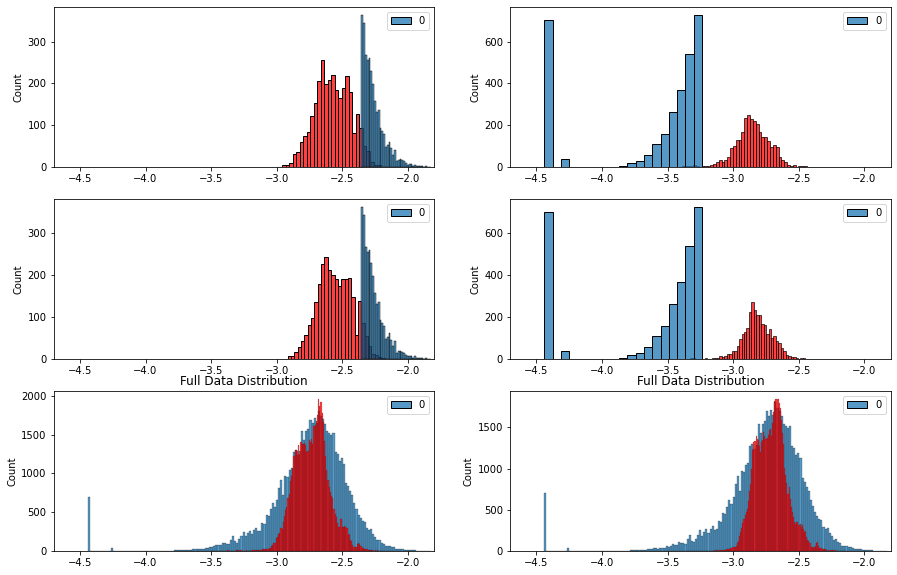

In [24]:
score_top, score_bottom = test_weighted({'base':regression_model_final, 'weighted_model':regression_model_weighted},\
    X, y)

In [ ]:
pd.DataFrame(score_top).to_csv('top500_scores.csv')
pd.DataFrame(score_bottom).to_csv('bot500_scores.csv')